In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os


In [2]:
!ls /kaggle/input/histopathologic-cancer-detection/

sample_submission.csv  test  train  train_labels.csv


In [3]:
#!cat /kaggle/input/histopathologic-cancer-detection/

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import cv2
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.optim as optim
from torch.optim import lr_scheduler

import json
from matplotlib.ticker import FormatStrFormatter
import copy
from collections import OrderedDict
from tqdm import tqdm_notebook as tqdm


%matplotlib inline

In [5]:
base_dir = "/kaggle/input/histopathologic-cancer-detection/"

In [6]:
labels =  pd.read_csv(base_dir + 'train_labels.csv')
labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [7]:
#labels = labels.sample(100000)

In [8]:
labels.shape

(220025, 2)

In [9]:
# Check data in train / test

print(len(os.listdir(base_dir + 'train')))
print(len(os.listdir(base_dir + 'test')))

220025
57458


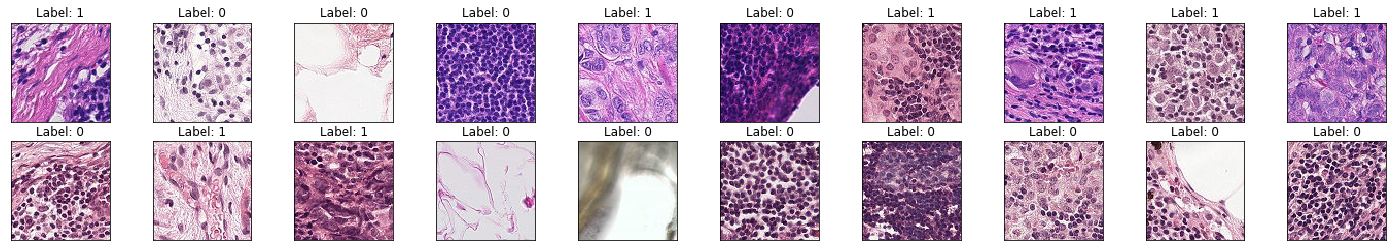

In [10]:
fig = plt.figure(figsize=(25, 4))
from PIL import Image as image_open
# display 20 images
train_imgs = os.listdir(base_dir + "./train")
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = image_open.open(base_dir + "./train/" + img)
    plt.imshow(im)
    lab = labels.loc[labels['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title(f'Label: {lab}')

In [11]:
# Class distribution count in training dataset

labels['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [12]:
# Split the training dataset to training and validation

train,valid = train_test_split(labels,stratify=labels.label,test_size= 0.20,random_state= 42)
print(len(train),len(valid))


176020 44005


In [13]:
train.head()

,id,label
198607,cffe7a3ffc48700045fd37f1f448b5a892ff4f2c,0
14684,b5bef3e7d7e8cc81e38fa2288105fc1c130e771a,0
55923,6fe4413a3a982af28a6e78d0f445073c509b4b33,0
215817,d6b4fe580210f5ea61b7c109b5c2e5cc734c3010,0
10219,1b6b051e370ca8468253d2e40f686c66eecb1619,1


In [15]:
train_path  = base_dir + 'train'
test_path  = base_dir + 'test'

In [16]:
train['label'].value_counts()

0    104726
1     71294
Name: label, dtype: int64

In [17]:
# Custom Data generator


class CancerDataset(Dataset):
    def __init__(self, df_data,data_dir= './',transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name+'.tif')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label


In [18]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 256


In [22]:
trans_train = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Pad(64, padding_mode='reflect'),
                                  transforms.RandomHorizontalFlip(), 
                                  transforms.RandomVerticalFlip(),
                                  transforms.RandomRotation(20), 
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

trans_valid = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Pad(64, padding_mode='reflect'),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

train_dataset = CancerDataset(df_data=train, data_dir=train_path, transform=trans_train)
valid_dataset = CancerDataset(df_data=valid, data_dir=train_path, transform=trans_valid)

train_loader = DataLoader(dataset = train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(dataset = valid_dataset, batch_size=batch_size//2, shuffle=False, num_workers=0)

In [23]:
class SimpleCNN(nn.Module):
    def __init__(self):
        # ancestor constructor call
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=2)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=2)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avg = nn.AvgPool2d(8)
        self.fc = nn.Linear(512 * 1 * 1, 2) # !!!
    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x)))) # first convolutional layer then batchnorm, then activation then pooling layer.
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = self.pool(F.leaky_relu(self.bn4(self.conv4(x))))
        x = self.pool(F.leaky_relu(self.bn5(self.conv5(x))))
        x = self.avg(x)
        #print(x.shape) # lifehack to find out the correct dimension for the Linear Layer
        x = x.view(-1, 512 * 1 * 1) # !!!
        x = self.fc(x)
        return x

In [24]:
num_epochs = 10
num_classes = 2
batch_size = 256
learning_rate = 0.002

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN().to(device)

In [26]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)

In [30]:
# Train the model
total_step = len(train_loader)
for epoch in tqdm(range(num_epochs)):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))


Epoch [1/10], Step [100/688], Loss: 0.4282
Epoch [1/10], Step [200/688], Loss: 0.3439
Epoch [1/10], Step [300/688], Loss: 0.3057
Epoch [1/10], Step [400/688], Loss: 0.3755
Epoch [1/10], Step [500/688], Loss: 0.4143
Epoch [1/10], Step [600/688], Loss: 0.3376
Epoch [2/10], Step [100/688], Loss: 0.2734
Epoch [2/10], Step [200/688], Loss: 0.2511
Epoch [2/10], Step [300/688], Loss: 0.3254
Epoch [2/10], Step [400/688], Loss: 0.2665
Epoch [2/10], Step [500/688], Loss: 0.2620
Epoch [2/10], Step [600/688], Loss: 0.2438
Epoch [3/10], Step [100/688], Loss: 0.2739
Epoch [3/10], Step [200/688], Loss: 0.2432
Epoch [3/10], Step [300/688], Loss: 0.1728
Epoch [3/10], Step [400/688], Loss: 0.2822
Epoch [3/10], Step [500/688], Loss: 0.2048
Epoch [3/10], Step [600/688], Loss: 0.1959
Epoch [4/10], Step [100/688], Loss: 0.1397
Epoch [4/10], Step [200/688], Loss: 0.1917
Epoch [4/10], Step [300/688], Loss: 0.2506
Epoch [4/10], Step [400/688], Loss: 0.1779
Epoch [4/10], Step [500/688], Loss: 0.1805
Epoch [4/10

In [40]:
# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model on the test images: 93.48483126917395 %


In [45]:
from IPython.display import FileLink

In [46]:
FileLink('model.ckpt')

/kaggle/working/model.ckpt